In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from tqdm import tqdm

### Merging the data and Feature Engineering

In [42]:
df=pd.read_csv("D:/Applied Ai/Datasets/QuoraQuestionpairsimilarity/train (1).csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [43]:
dfnlpfeat = pd.read_csv("D:/Applied Ai/Datasets/QuoraQuestionpairsimilarity/nlp_features_train.csv",encoding='latin-1')
dfpprofeat = pd.read_csv("D:/Applied Ai/Datasets/QuoraQuestionpairsimilarity/df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [44]:
df1 = dfnlpfeat.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfpprofeat.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlpfeat[['id','question1','question2']]
duplicate = dfnlpfeat.is_duplicate


In [45]:
df3.isnull().sum()

id            0
question1    15
question2     6
dtype: int64

In [46]:
df3 = df3.fillna(' ')
df3.isnull().sum()

id           0
question1    0
question2    0
dtype: int64

In [47]:
df3["questions"]=df3["question1"]+' '+df3["question2"]
df3.head()

,id,question1,question2,questions
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,what is the story of kohinoor koh i noor dia...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,how can i increase the speed of my internet co...
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,why am i mentally very lonely how can i solve...
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,which one dissolve in water quikly sugar salt...


In [48]:
final_df=df1.merge(df2,on='id',how='left')
X=final_df.merge(df3,on='id',how='left')


In [49]:
X=X.drop(['id','question1', 'question2'],axis=1) #removing id from X
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [50]:
y=np.array(duplicate)

In [52]:
# taking 100k data points
X=X.iloc[:100000,:]
y=y[:100000]
X.shape

(100000, 27)

In [53]:
import pickle
with open('X','wb') as f :
    pickle.dump(X,f)
with open('y','wb') as f :
    pickle.dump(y,f)

In [8]:
import pickle
with open('X','rb') as f :
    X=pickle.load(f)
with open('y','rb') as f :
    y=pickle.load(f)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 27)
(70000,)
(30000, 27)
(30000,)


In [10]:
X_tr_ques=X_train['questions']
X_test_ques=X_test['questions']
X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# list_of_sentance_train=[]
# for sentance in X_train_ques:
#     list_of_sentance_train.append(sentance.split())

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(X_tr_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [62]:
conda install -c conda-forge/label/cf202003 spacy-model-en_core_web_sm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Python

  added / updated specs:
    - spacy-model-en_core_web_sm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge/label/cf202003
    spacy-model-en_core_web_sm-2.2.5|             py_0        11.8 MB  conda-forge/label/cf202003
    ------------------------------------------------------------
                                           Total:        11.9 MB

The following NEW packages will be INSTALLED:

  spacy-model-en_co~ conda-forge/label/cf202003/noarch::spacy-model-en_core_web_sm-2.2.5-py_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                         pkgs/main --> conda-forge/label/cf202003




spacy-model-en_core_ | 11.8 MB   |            |   0% 
spacy-model-en

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_tr_ques)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

100%|██████████| 70000/70000 [11:46<00:00, 99.07it/s] 


In [23]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector) ])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

100%|██████████| 30000/30000 [04:58<00:00, 100.66it/s]


In [62]:
first_df=pd.DataFrame(vecs1)
sec_df=pd.DataFrame(vecs2)
first_df.shape

(70000, 96)

In [79]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [80]:
from scipy.sparse import hstack

X_train_w2v = np.vstack((np.transpose(X_train),np.transpose(vecs1))).T
X_test_w2v=np.vstack((np.transpose(X_test),np.transpose(vecs2))).T 


In [85]:
with open('X_train_w2v','wb') as f :
    pickle.dump(X_train_w2v,f)
with open('X_test_w2v','wb') as f :
    pickle.dump(X_test_w2v,f)

<h1>4. Machine Learning Models </h1>

In [11]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6259714285714286 Class 1:  0.37402857142857143
---------- Distribution of output variable in train data ----------
Class 0:  0.36906666666666665 Class 1:  0.36906666666666665


In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
   

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8897821215544328
[[0.38994698 0.61005302]
 [0.22033771 0.77966229]
 [0.3697519  0.6302481 ]
 ...
 [0.54551315 0.45448685]
 [0.00840116 0.99159884]
 [0.4613665  0.5386335 ]]


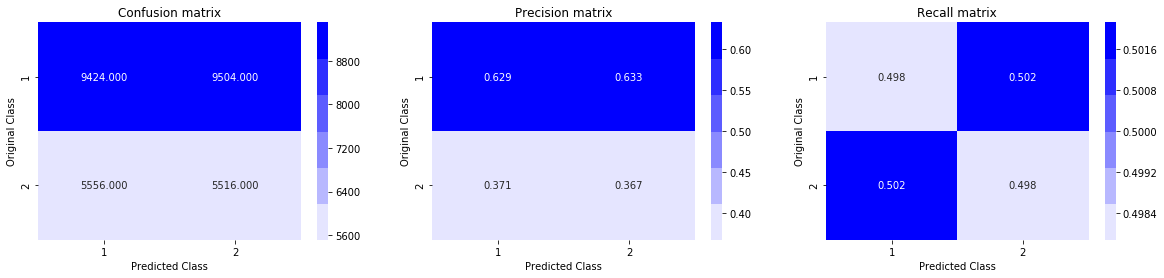

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics import confusion_matrix

predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
print(predicted_y)
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [14]:
def log_reg(X_train,X_test,y_train,y_test):
    alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

    # read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
    # ------------------------------
    # default parameters
    # SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
    # shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
    # class_weight=None, warm_start=False, average=False, n_iter=None)

    # some of methods
    # fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
    # predict(X)	Predict class labels for samples in X.

    #-------------------------------
    # video link: 
    #------------------------------


    log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_test)
        log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(alpha, log_error_array,c='g')
    for i, txt in enumerate(np.round(log_error_array,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(log_error_array)
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    predict_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    predicted_y =sig_clf.predict(X_test)
    print("Total number of data points :", len(predicted_y))
    plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression -TFIDFW2V

For values of alpha =  1e-05 The log loss is: 0.5667606442214067
For values of alpha =  0.0001 The log loss is: 0.4582241516709656
For values of alpha =  0.001 The log loss is: 0.4556018099548582
For values of alpha =  0.01 The log loss is: 0.46106309303804155
For values of alpha =  0.1 The log loss is: 0.4643902610208294
For values of alpha =  1 The log loss is: 0.48790215631332234
For values of alpha =  10 The log loss is: 0.5417098246282454


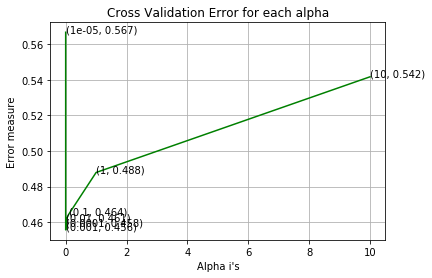

For values of best alpha =  0.001 The train log loss is: 0.45423099285637963
For values of best alpha =  0.001 The test log loss is: 0.4556018099548582
Total number of data points : 30000


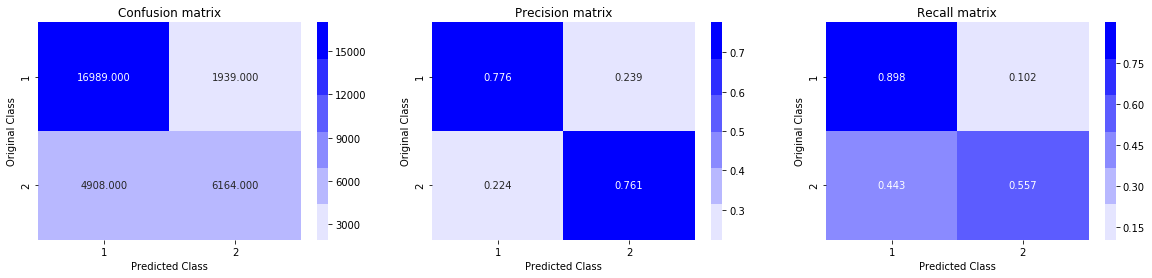

In [109]:
# runnining the logistic regression function
log_reg(X_train_w2v,X_test_w2v,y_train,y_test)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

In [15]:
def lr_svm(X_train,X_test,y_train,y_test):
    alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

    # read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
    # ------------------------------
    # default parameters
    # SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
    # shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
    # class_weight=None, warm_start=False, average=False, n_iter=None)

    # some of methods
    # fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
    # predict(X)	Predict class labels for samples in X.

    #-------------------------------
    # video link: 
    #------------------------------


    log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_test)
        log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(alpha, log_error_array,c='g')
    for i, txt in enumerate(np.round(log_error_array,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(log_error_array)
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    predict_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    predicted_y =clf.predict(X_test)
    print("Total number of data points :", len(predicted_y))
    plot_confusion_matrix(y_test, predicted_y)

### Linear SVM-TFIDFW2V

For values of alpha =  1e-05 The log loss is: 0.6585099780392267
For values of alpha =  0.0001 The log loss is: 0.6585099780392267
For values of alpha =  0.001 The log loss is: 0.5881934529499151
For values of alpha =  0.01 The log loss is: 0.4881601036678271
For values of alpha =  0.1 The log loss is: 0.5475705434992909
For values of alpha =  1 The log loss is: 0.6295541915062207
For values of alpha =  10 The log loss is: 0.6579039559192923


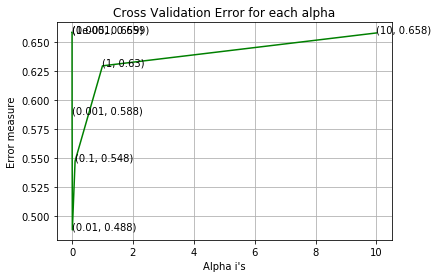

For values of best alpha =  0.01 The train log loss is: 0.49436856992820455
For values of best alpha =  0.01 The test log loss is: 0.4881601036678271
Total number of data points : 30000


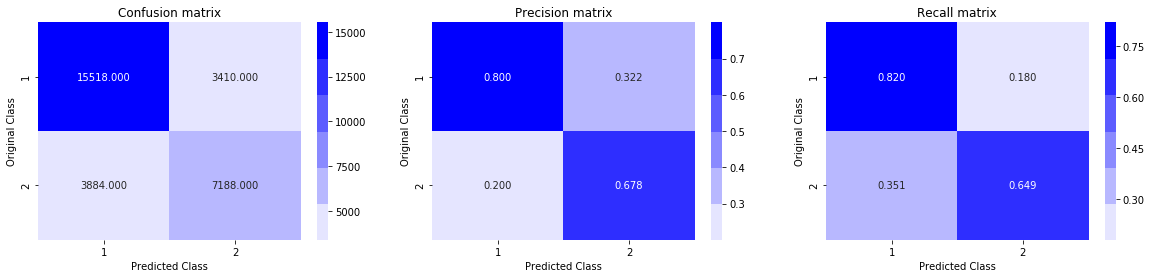

In [111]:
#fiiting the data using the svm model
lr_svm(X_train_w2v,X_test_w2v,y_train,y_test)

<h2> 4.6 XGBoost </h2>

In [114]:

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_w2v, label=y_train)
d_test = xgb.DMatrix(X_test_w2v, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_w2v,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68487	valid-logloss:0.68485
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61605	valid-logloss:0.61599
[20]	train-logloss:0.56509	valid-logloss:0.56497
[30]	train-logloss:0.52726	valid-logloss:0.52711
[40]	train-logloss:0.49776	valid-logloss:0.49774
[50]	train-logloss:0.47491	valid-logloss:0.47510
[60]	train-logloss:0.45692	valid-logloss:0.45729
[70]	train-logloss:0.44227	valid-logloss:0.44280
[80]	train-logloss:0.43047	valid-logloss:0.43121
[90]	train-logloss:0.42075	valid-logloss:0.42172
[100]	train-logloss:0.41258	valid-logloss:0.41372
[110]	train-logloss:0.40590	valid-logloss:0.40718
[120]	train-logloss:0.40007	valid-logloss:0.40158
[130]	train-logloss:0.39527	valid-logloss:0.39687
[140]	train-logloss:0.39100	valid-logloss:0.39278
[150]	train-logloss:0.38723	valid-logloss:0.38924
[160]	train-logloss:0.38407	valid-logloss:0.38631
[170]	trai

Total number of data points : 30000


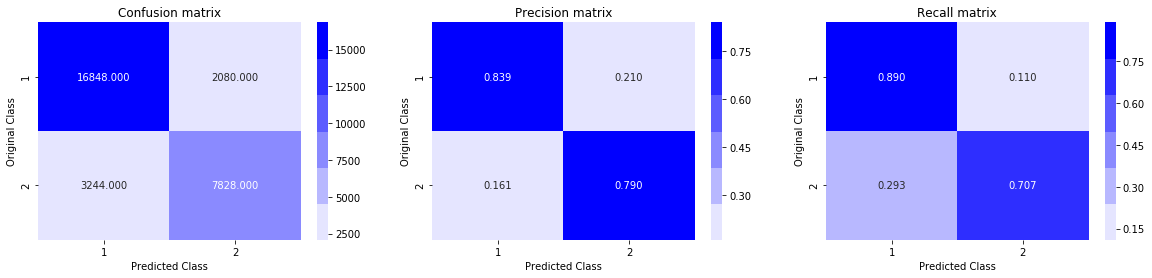

In [115]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Hyperparameter Tuning XGboost using Random Search

In [116]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[1,5,10,50,100,500,1000],
              "n_estimators":[50,100,150,200,300,400,500]}
clf_xgb = xgb.XGBClassifier()
model = RandomizedSearchCV(clf_xgb, param_distributions=param_grid,scoring='neg_log_loss')
model.fit(X_train_w2v,y_train)
model.best_params_

{'n_estimators': 100, 'max_depth': 5}

Train log loss =  0.2679294073244041  Test log loss =  0.3408549307225352


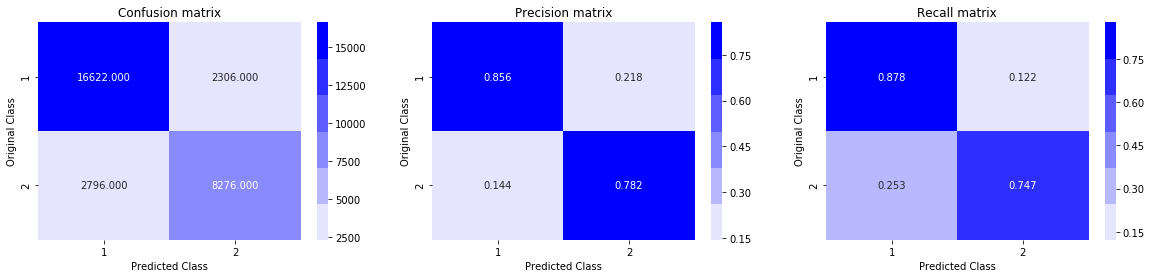

In [120]:
#now fitting the parameters
clf=xgb.XGBClassifier(random_state=25,max_depth=5,n_estimators=100)
clf.fit(X_train_w2v,y_train)
y_pred_test=clf.predict_proba(X_test_w2v)
y_pred_train=clf.predict_proba(X_train_w2v)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=clf.predict(X_test_w2v)
plot_confusion_matrix(y_test,predicted_y)

Although test prediction is good ,due to large gap in test and train loss the model is overfitting.

## USING TFIDF 

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 27)
(70000,)
(30000, 27)
(30000,)


In [17]:
X_tr_ques=X_train['questions']
X_test_ques=X_test['questions']
X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)


In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vec1=tf_idf_vect.fit_transform(X_tr_ques)
vec2=tf_idf_vect.transform(X_test_ques)

In [21]:
X_train_tfidf = hstack((X_train.values,vec1))
X_test_tfidf= hstack((X_test.values,vec2))

### Logistic Regression-TFIDF

For values of alpha =  1e-05 The log loss is: 0.4340030445107614
For values of alpha =  0.0001 The log loss is: 0.4195630181625581
For values of alpha =  0.001 The log loss is: 0.4248116397493368
For values of alpha =  0.01 The log loss is: 0.45610190969640896
For values of alpha =  0.1 The log loss is: 0.4627182819280148
For values of alpha =  1 The log loss is: 0.4957515959268263
For values of alpha =  10 The log loss is: 0.5457523202239005


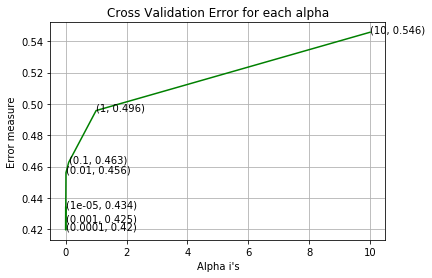

For values of best alpha =  0.0001 The train log loss is: 0.4160527780432016
For values of best alpha =  0.0001 The test log loss is: 0.4195630181625581
Total number of data points : 30000


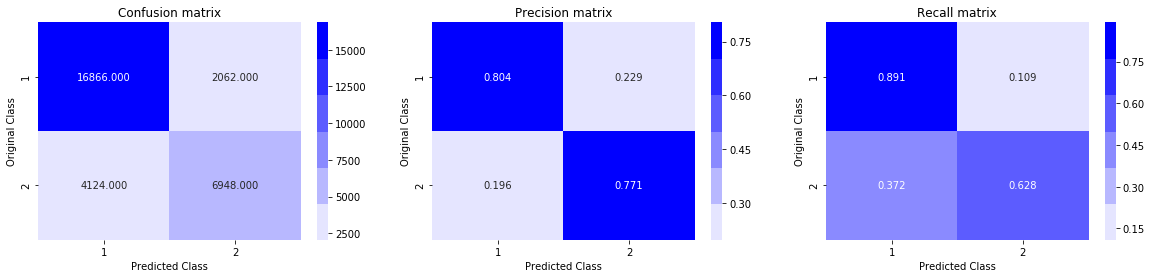

In [24]:
#fitting  the data to logistic regression
log_reg(X_train_tfidf,X_test_tfidf,y_train,y_test)

### Linear SVM-TFIDF

For values of alpha =  1e-05 The log loss is: 0.436777383836121
For values of alpha =  0.0001 The log loss is: 0.46214352160807454
For values of alpha =  0.001 The log loss is: 0.4845946654416849
For values of alpha =  0.01 The log loss is: 0.5195647114863139
For values of alpha =  0.1 The log loss is: 0.47881233720336164
For values of alpha =  1 The log loss is: 0.5916997298768512
For values of alpha =  10 The log loss is: 0.6468072334208979


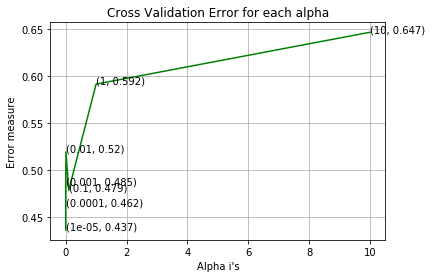

For values of best alpha =  1e-05 The train log loss is: 0.43227450771906223
For values of best alpha =  1e-05 The test log loss is: 0.436777383836121
Total number of data points : 30000


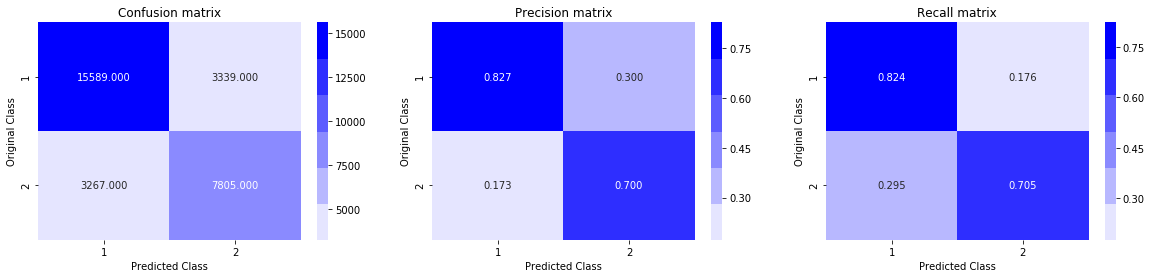

In [25]:
lr_svm(X_train_tfidf,X_test_tfidf,y_train,y_test)

### Conclusions

In [30]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","Train-log loss","Test-log loss"]
x.add_row(['Logistic regression','TFIDF w2vec','0.455','0.455'])
x.add_row(['Linear SVM','TFIDF w2vec','0.48816','0.488'])
x.add_row(['XGBOOST-Without hyper tuning','TFIDF w2vec','0.34','0.35'])
x.add_row(['XGBOOST-With hyper tuning','TFIDF w2vec','0.26','0.34'])
x.add_row(['Logistic regression','TFIDF ','0.41','0.41'])
x.add_row(['Linear SVM','TFIDF','0.43','0.43'])

print(x)


+------------------------------+-------------+----------------+---------------+
|            Model             |  Vectorizer | Train-log loss | Test-log loss |
+------------------------------+-------------+----------------+---------------+
|     Logistic regression      | TFIDF w2vec |     0.455      |     0.455     |
|          Linear SVM          | TFIDF w2vec |    0.48816     |     0.488     |
| XGBOOST-Without hyper tuning | TFIDF w2vec |      0.34      |      0.35     |
|  XGBOOST-With hyper tuning   | TFIDF w2vec |      0.26      |      0.34     |
|     Logistic regression      |    TFIDF    |      0.41      |      0.41     |
|          Linear SVM          |    TFIDF    |      0.43      |      0.43     |
+------------------------------+-------------+----------------+---------------+


From the above tables we can safely conclude that XGboost without hypertuning has given us the least log loss ,hence the best model

### Summary

1) First we did Exploratory Data Analysis on Quora Question Pair in which we performed such as finding number of different questions, checking for duplicates, number of occurence of questions etc. 2) Then we performed some feature extraction like fuzz ratio, fuzz partial ration, longest common substring etc. 3) After performing feature extraction we applied some visualisation techniques such as pair-plot, violin plot, TSNE etc. 4) Then we peformed tfidf-w2vec vectorizer on pair of questions dataset and then we merged each tfidf-w2vec vectors to our advanced featured vectors. 5) In the next step we applied machine learning algorithms such as logistic regression, support vector machines and XGBoost and found log-loss for both train and test dataset using both tfidfw2v and tfidf featurization. 6) After choosing best parameters we then plotted confusion matrix, precision matrix and recall matrix for each model.7) We chose the best model based on log loss metric